In [55]:
import numpy as np
import os
from math import log

path = "messages"

datasets = []
for dataset in os.scandir(path):
    if not dataset.is_dir():
        continue
    datasets.append([])
    for file_name in os.scandir(f"{path}/{dataset.name}"):
        label = 0 if "spmsg" in file_name.name else 1
        file = open(file_name, "r")
        subject = list(map(int, file.readline().split()[1::]))
        file.readline()
        content = list(map(int, file.readline().split()))
        datasets[len(datasets) - 1].append((label, subject, content))

datasets = np.array(datasets)

/var/folders/rq/sg13x7f91f9b_m60s_21b_540000gn/T/ipykernel_9822/2785111518.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  datasets = np.array(datasets)


In [60]:
CLASSES = 2
eps = 1e-4

def email_to_words(n, subject, content):
    words = set()
    for i in range(len(subject) - n + 1):
        n_gram = " ".join(list(map(str, subject[i : (i + n)])))
        words.add(n_gram)

    for i in range(len(content) - n + 1):
        n_gram = " ".join(list(map(str, content[i : (i + n)])))
        words.add(n_gram)

    return words

def calc_n_grams(dataset, n):
    n_grams = {
        0: {},
        1: {}
    }
    label_freq = [0] * CLASSES
    vocab = set()
    for (label, subject, content) in dataset:
        label_freq[label] += 1
        words = email_to_words(n, subject, content)
        for word in words:
            n_grams[label][word] = n_grams[label].get(word, 0) + 1
            vocab.add(word)

    return n_grams, label_freq, vocab

def bayes(alpha, n, lambdas, train_dataset, test_dataset):
    n_grams, label_freq, words = calc_n_grams(train_dataset, n)

    p = [0] * CLASSES

    for label in range(CLASSES):
        denominator = label_freq[label] + 2 * alpha
        prob = [0] * len(words)
        i = 0
        for word in words:
            prob[i] = (n_grams[label].get(word, 0) + alpha) / denominator
            i += 1
        p[label] = prob

    y_preds = []
    for (label, subject, content) in test_dataset:
        x = email_to_words(n, subject, content)
        values = [0] * CLASSES
        for y in range(CLASSES):
            p_xy = 0
            i = 0
            for word in words:
                if word in x:
                    p_xy += log(p[y][i])
                else:
                    p_xy += log(1 - p[y][i])
                i += 1
            values[y] = log(lambdas[y]) + log(label_freq[y] / n) + p_xy
        sm = 0
        max_ln = max(values)
        for y in range(CLASSES):
            if abs(values[y]) <= eps:
                values[y] = 0
                continue
            values[y] = np.exp(values[y] - max_ln)
            sm += values[y]

        for y in range(CLASSES):
            values[y] /= sm

        y_pred = np.array(values).argmax()
        y_preds.append(y_pred)

    return y_preds

In [61]:
from sklearn.model_selection import KFold

def run_bayes(alpha, n, lambdas):
    kf = KFold(n_splits=10)
    accuracies = []
    classified_legit_as_spam = False
    for train_index, test_index in kf.split(datasets):
        test_dataset = datasets[test_index[0]]
        train_dataset = []
        for i in train_index:
            train_dataset.extend(datasets[i])
        train_dataset = np.array(train_dataset)
        y_preds = bayes(alpha, n, lambdas, train_dataset, test_dataset)
        correct = 0
        for i in range(len(test_dataset)):
            label = test_dataset[i][0]
            y_pred = y_preds[i]
            if label == y_pred:
                correct += 1
            if y_pred == 0 and label == 1:
                classified_legit_as_spam = True
        accuracies.append(correct / len(test_dataset))

    return np.array(accuracies).mean(), classified_legit_as_spam

In [ ]:
EPOCHS = 2
DEG_START = 50
DEG_STEP = 20
DEG_ITERS = 8

best_accuracy = 0
best_params = ()
for i in range(EPOCHS):
    alpha = 10 ** (np.random.uniform(-9, -5))
    print(f"alpha: {alpha}")
    for n in range(1, 4):
        print(f"  n: {n}")
        lambdas = [1, 0]
        found_lambda = False
        deg = DEG_START
        while not found_lambda and deg < (DEG_START + DEG_ITERS * DEG_STEP):
            lambdas[1] = 10 ** deg
            print(f"    lambda deg: {deg}")
            accuracy, classified_legit_as_spam = run_bayes(alpha, n, lambdas)
            print(f"    classified legit as spam: {classified_legit_as_spam}, accuracy: {accuracy}")
            if not classified_legit_as_spam and accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = (alpha, n, *lambdas)
            found_lambda = not classified_legit_as_spam
            deg += DEG_STEP

alpha: 3.9595586114287164e-09
  n: 1
    lambda deg: 50
    classified legit as spam: True, accuracy: 0.8825688073394498
    lambda deg: 70
    classified legit as spam: False, accuracy: 0.8357798165137614
  n: 2
    lambda deg: 50
    classified legit as spam: True, accuracy: 0.9513761467889909
    lambda deg: 70
    classified legit as spam: True, accuracy: 0.9449541284403671
    lambda deg: 90
    classified legit as spam: True, accuracy: 0.9330275229357798
    lambda deg: 110
    classified legit as spam: True, accuracy: 0.9238532110091745
    lambda deg: 130
    classified legit as spam: True, accuracy: 0.9091743119266056
    lambda deg: 150
    classified legit as spam: True, accuracy: 0.9009174311926605
    lambda deg: 170
    classified legit as spam: True, accuracy: 0.8963302752293579
    lambda deg: 190
    classified legit as spam: True, accuracy: 0.8908256880733945
  n: 3
    lambda deg: 50
    classified legit as spam: True, accuracy: 0.9266055045871561
    lambda deg: 70


In [59]:
print(f"best accuracy: {best_accuracy}")
print(f"alpha: {best_params[0]}, n: {best_params[1]}, lambda_spam: {best_params[2]}, lambda_legit: {best_params[3]}")



best accuracy: 0.8871559633027524
alpha: 3.9595586114287164e-09, n: 3, lambda_spam: 1, lambda_legit: 1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


AUC = 0.87


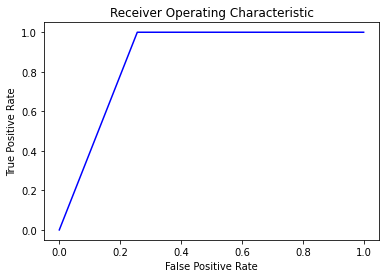

In [65]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
plt.style.use({'figure.facecolor':'white'})

alpha, n, lambda_spam, lambda_legit = best_params
lambdas = [lambda_spam, lambda_legit]

kf = KFold(n_splits=10)
y_preds = []
labels = []
for train_index, test_index in kf.split(datasets):
    test_dataset = datasets[test_index[0]]
    train_dataset = []
    for i in train_index:
        train_dataset.extend(datasets[i])
    train_dataset = np.array(train_dataset)
    y_preds.extend(bayes(alpha, n, lambdas, train_dataset, test_dataset))
    labels.extend(list(map(lambda tp: tp[0], test_dataset)))

fpr, tpr, _ = metrics.roc_curve(labels, y_preds)
roc_auc = metrics.auc(fpr, tpr)
print('AUC = %0.2f' % roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [66]:
xs = []
accuracies = []
curr_lambda = lambda_spam
while curr_lambda <= lambda_legit:
    xs.append(curr_lambda)
    accuracies.append(run_bayes(alpha, n, [lambda_spam, curr_lambda]))
    curr_lambda = curr_lambda * (10 ** 30)
    
accuracies = list(map(lambda pr: pr[0], accuracies))

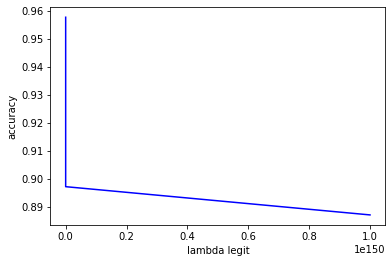

In [71]:
plt.plot(xs, accuracies, "b")
plt.xlabel("lambda legit")
plt.ylabel("accuracy")
plt.show()
